<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Let's display the architecture of your model so far:


### Load data

In [6]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip

--2024-11-26 22:35:48--  https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 3.5.225.182, 3.5.204.157
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|3.5.225.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131852014 (126M) [application/zip]
Saving to: ‘UTKFace.zip’

UTKFace.zip         100%[===================>] 125.74M  35.6MB/s    in 4.2s    

2024-11-26 22:35:53 (30.3 MB/s) - ‘UTKFace.zip’ saved [131852014/131852014]



### Evaluate the model

In [7]:
!jar xf UTKFace.zip

# Новый раздел

Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import glob
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the dataset

##### Copyright 2019 The TensorFlow Authors.

In [6]:
BASE_DIR = 'UTKFace/'

In [7]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,UTKFace/31_0_4_20170120133240958.jpg.chip.jpg,31,0
1,UTKFace/58_0_3_20170119211657945.jpg.chip.jpg,58,0
2,UTKFace/26_1_4_20170117201620471.jpg.chip.jpg,26,1
3,UTKFace/20_1_3_20170104222019511.jpg.chip.jpg,20,1
4,UTKFace/26_1_0_20170117173257366.jpg.chip.jpg,26,1


In [9]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

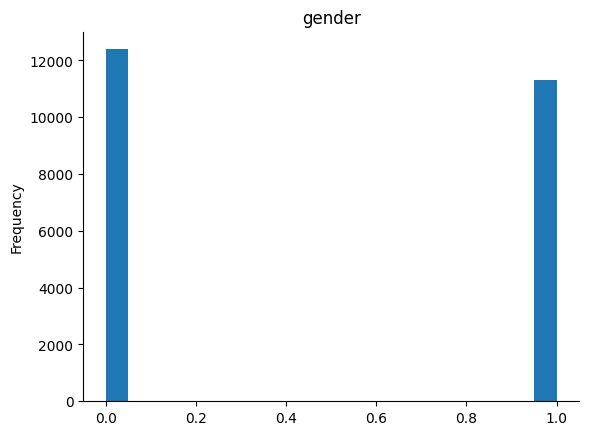

In [19]:
# @title gender

from matplotlib import pyplot as plt
df['gender'].plot(kind='hist', bins=20, title='gender')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='age', ylabel='Density'>

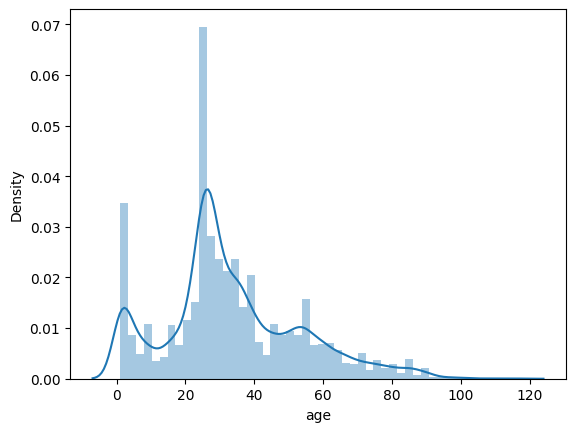

In [21]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

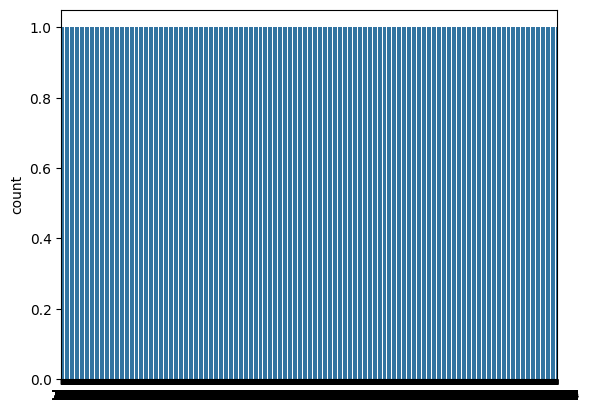

In [30]:
sns.countplot(df['gender'])

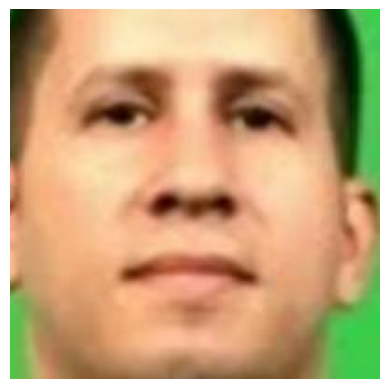

In [29]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

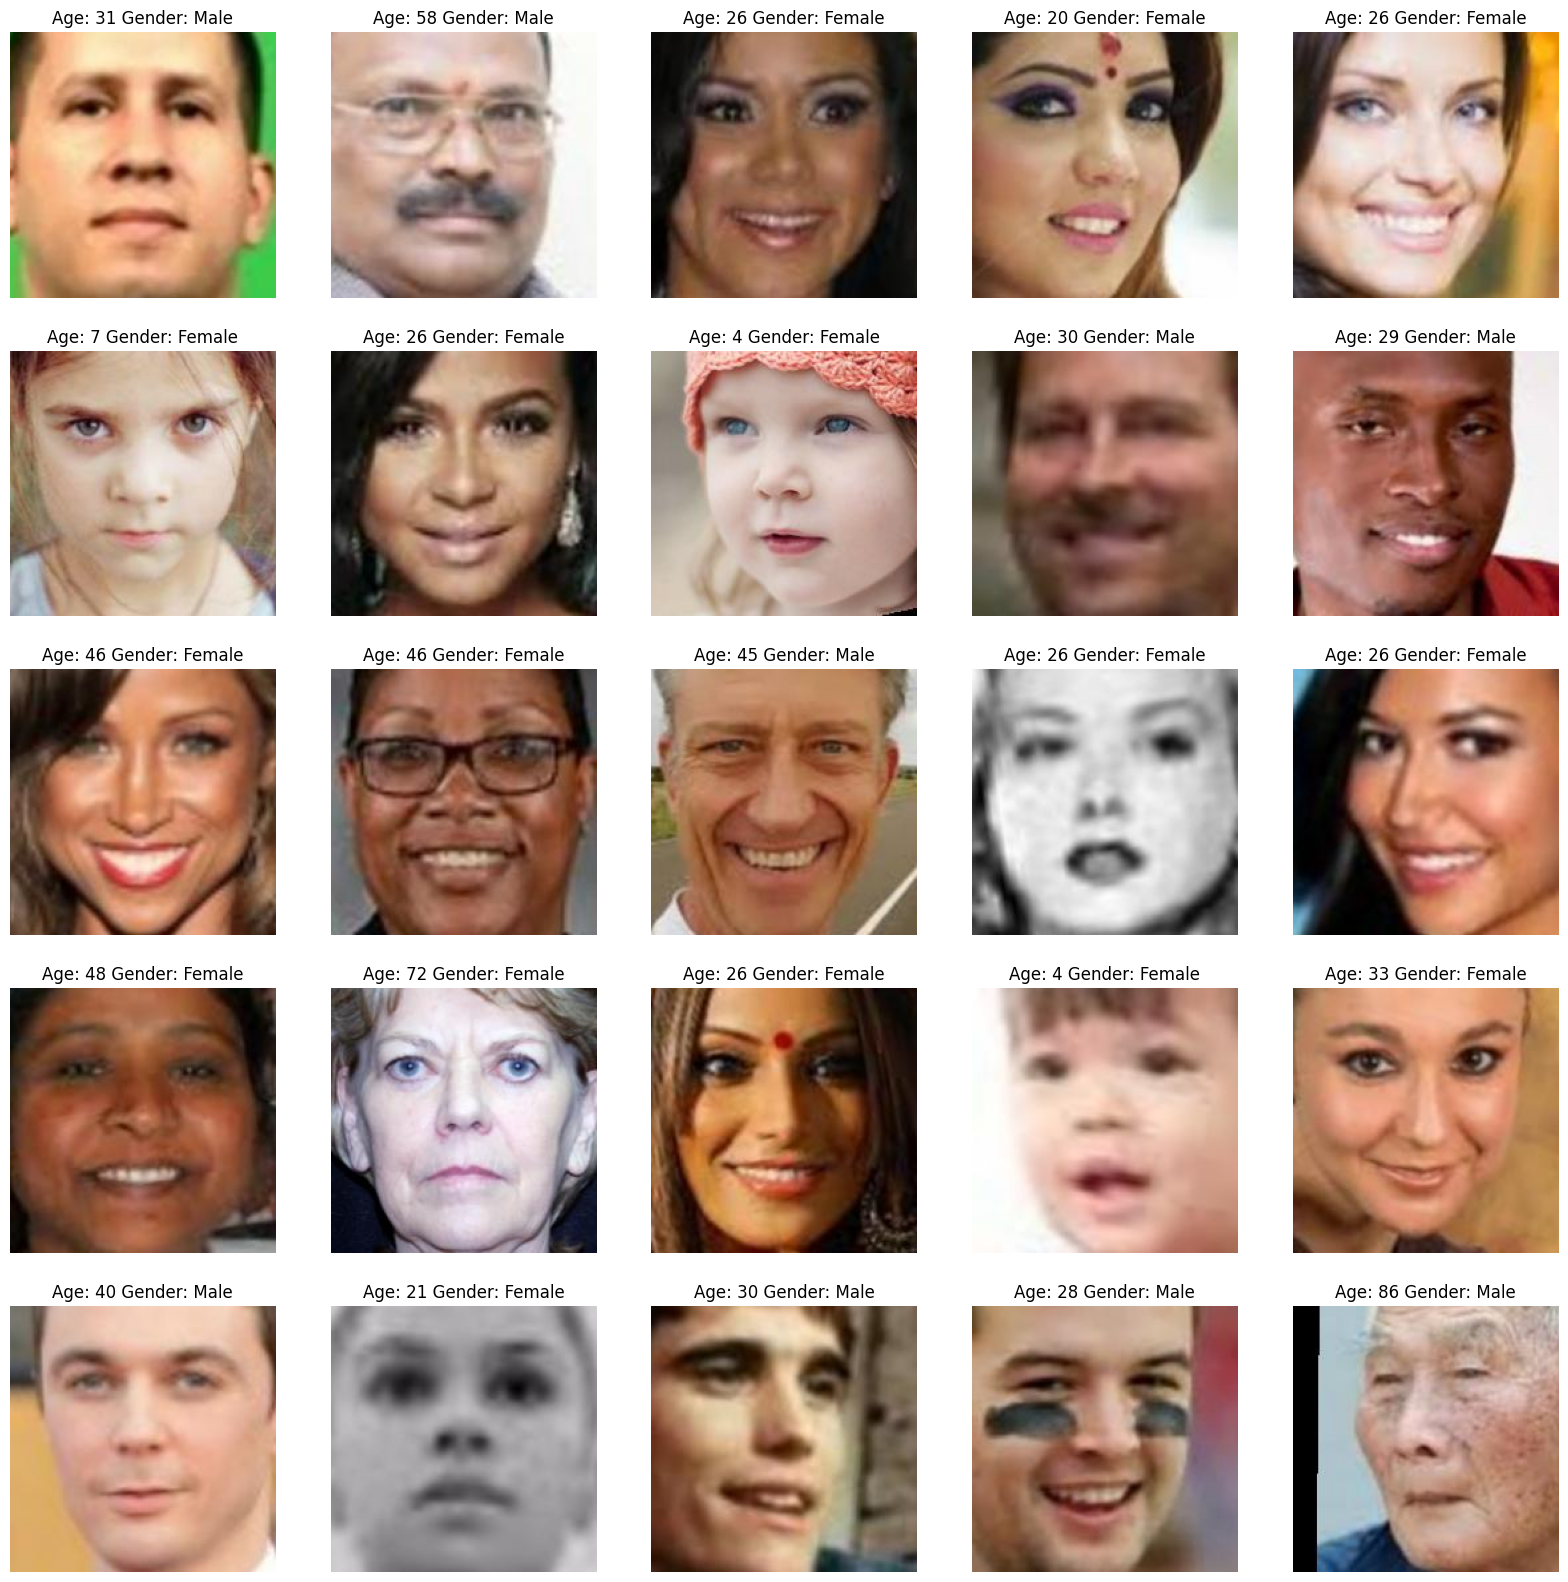

In [31]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [12]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
input_shape = (128, 128, 1)

In [16]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)


Epoch 1/30
227/593 ━━━━━━━━━━━━━━━━━━━━ 8:14 1s/step - age_out_loss: 18.0606 - age_out_mae: 18.0606 - gender_out_accuracy: 0.5176 - gender_out_loss: 0.7370 - loss: 18.7976